# Introduction to Pytorch
Code is based off of the PyTorch website tutorials here: https://docs.pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

## Datasets and DataLoaders

In [1]:
# read in packages
import torch
from torch import nn
from torch.utils.data import DataLoader # wraps an iterable around the Dataset
from torchvision import datasets #  stores the samples and their corresponding labels
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

First we can download datasets the use. Below is the FashionMNIST dataset from TorchVision. Fashion-MNIST is a dataset of Zalando’s article images consisting of 60,000 training examples and 10,000 test examples. Each example comprises a 28×28 grayscale image and an associated label from one of 10 classes.

In [2]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [3]:
training_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

In [4]:
# pass the Dataset as an argument to DataLoader. This wraps an iterable over our dataset, and 
# supports automatic batching, sampling, shuffling and multiprocess data loading

# will load 64 features and labels in one pass
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [ ]:
# EXERCISE — Inspect one batch
# TODO:
#   1) Grab one batch from train_dataloader
#   2) Print shapes of X and y
#   3) Print dtype + min/max of X
#   4) Confirm labels are in [0, 9]



In [ ]:
# EXERCISE — Compute class distribution in one batch
# TODO:
#   1) Use torch.bincount to count how many of each class (0..9) appear
#   2) Print the most common class index in this batch



So what does the dataset actually look like? We can index the datasets like a list

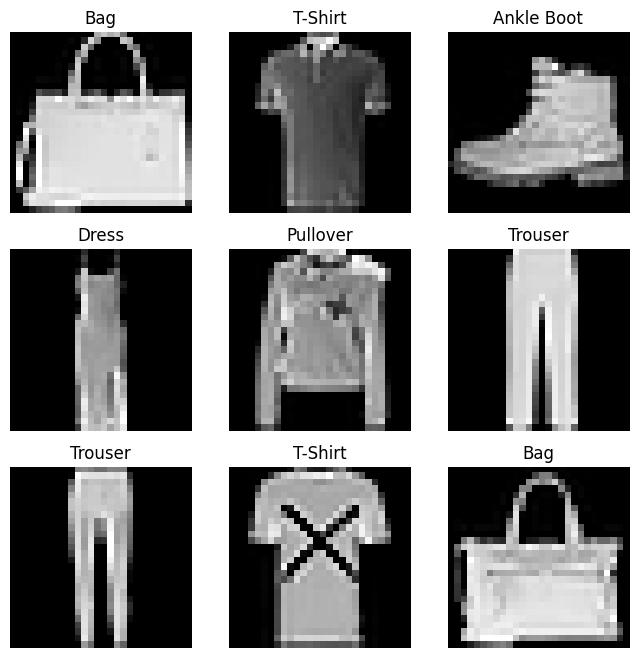

In [9]:
# class labels
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

# plot some sample images
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Creating a Custom Dataset for your files

A custom Dataset class must implement three functions: __init__, __len__, and __getitem__.

In [84]:
# read in packages
import os
import pandas as pd
from torchvision.io import decode_image

# create class
class CustomImageDataset(Dataset):
    # The __init__ function is run once when instantiating the Dataset object. 
    # We initialize the directory containing the images, the annotations file, 
    # and both transforms.
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    # The __len__ function returns the length of the dataset.
    def __len__(self):
        return len(self.img_labels)

    # The __getitem__ function loads and returns a sample from the dataset at the given index idx.
    # Based on the index, it identifies the image’s location on disk, converts that to a tensor 
    # using decode_image, retrieves the corresponding label from the csv data in self.img_labels, 
    # calls the transform functions on them (if applicable), and returns the tensor image and 
    # corresponding label in a tuple
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = decode_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [ ]:
# EXERCISE — Write a tiny dummy Dataset (no files)
# Goal: Practice the Dataset interface: __len__ and __getitem__
# This dataset generates random vectors x and binary labels y on-the-fly.

import torch
from torch.utils.data import Dataset



x0: tensor([ 1.5410, -0.2934, -2.1788]) shape: torch.Size([3])
y0: 0 type: <class 'int'>


In [101]:
# EXERCISE — DataLoader over your ToyDataset
# Goal: batch samples and check shapes.




### Preparing your data for training with DataLoaders

Again, a DataLoader is an iterable that abstracts this complexity for us in an easy API.

In [10]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


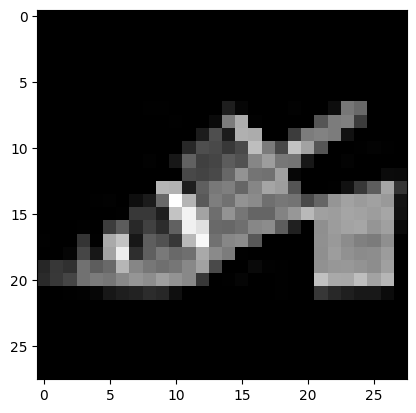

Label: 5
Label name: Sandal


In [25]:
# so we can iterate through them

# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")
print(f"Label name: {labels_map[label.item()]}")

## Transforms

Data does not always come in its final processed form that is required for training machine learning algorithms. We use transforms to perform some manipulation of the data and make it suitable for training.

All TorchVision datasets have two parameters -transform to modify the features and target_transform to modify the labels

The FashionMNIST features are in PIL Image format, and the labels are integers. For training, we need the features as normalized tensors, and the labels as one-hot encoded tensors. To make these transformations, we use ToTensor and Lambda.

In [26]:
# read in packages
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

# Download training data from open datasets.
ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    # # converts a PIL image or NumPy ndarray into a FloatTensor
    transform=ToTensor(),
    # Lambda transforms apply any user-defined lambda function. Here, we define a function 
    # to turn the integer into a one-hot encoded tensor. It first creates a zero tensor of size 10 
    # (the number of labels in our dataset) and calls scatter_ which assigns a value=1 on the index as given by the label y.
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

In [27]:
# example of one-hot encoding
image, label = ds[0]
print(image.shape, label.shape)
# TEST: what wil this print?
print(label)  # one-hot encoded tensor

torch.Size([1, 28, 28]) torch.Size([10])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])


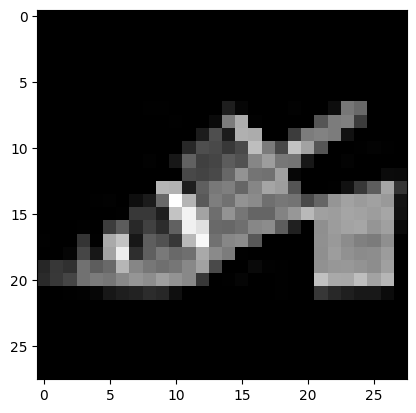

In [28]:
plt.imshow(img.cpu().squeeze(), cmap="gray")

In [36]:
# EXERCISE — Verify one-hot encoding correctness
# TODO:
#   1) Pick an index i
#   2) Check the one-hot label sums to 1
#   3) Recover the class with argmax and compare to the original integer label




In [ ]:
# EXERCISE — Add a normalization transform
# TODO:
#   1) Create a transform pipeline that converts to tensor and normalizes
#   2) Load a dataset with this transform
#   3) Print mean/std of one batch



## Building a Neural Network

The torch.nn namespace provides all the building blocks you need to build your own neural network.

In [37]:
# read in packages
import os
import torch
from torch import nn

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [38]:
# this will set device to GPU if available, else CPU
device = torch.cuda.current_device().type if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


### Defining a Class

In [40]:
# Defining a Class
class NeuralNetwork(nn.Module):
    # initialize the layers
    def __init__(self):
        # call the init function of the parent class nn.Module
        super().__init__()
        # define the layers
        self.flatten = nn.Flatten()
        # hidden layers with ReLU activations
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1*28*28, 512), # NOTE: why 1*28*28?
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    # define the forward pass
    def forward(self, x):
        # flatten the input tensor
        x = self.flatten(x)
        # pass through the layers
        logits = self.linear_relu_stack(x)
        # return the logits
        return logits

Now we have defined a class, we can create an instance of it

In [41]:
# create an instance of the class and print the model
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


### Model Layers

grab some images from dataset

In [47]:
input_image = torch.rand(1,3,28,28) # why the 1?
print(input_image.size())
# TEST: what will this image look like?
# plt.imshow(input_image.reshape(28,28,3))

torch.Size([1, 3, 28, 28])


In [48]:
# nn.Flatten
# We initialize the nn.Flatten layer to convert each 2D 28x28 image into a contiguous array of 784 pixel values 
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())

torch.Size([1, 2352])


In [55]:
# nn.Linear
# The linear layer is a module that applies a linear transformation on the input using its stored weights and biases.
layer1 = nn.Linear(in_features=3*28*28, out_features=20)
hidden1 = layer1(flat_image)
# print(hidden1.size())
# TEST: what will this print?
# print(hidden1)

In [59]:
# nn.ReLU
# Non-linear activations are what create the complex mappings between the model’s inputs and outputs. 
# They are applied after linear transformations to introduce nonlinearity
print(f"Before ReLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
# TEST: what will this print?
# print(f"After ReLU: {hidden1}")

Before ReLU: tensor([[0.3421, 0.5470, 0.0000, 0.0443, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.2968, 0.0000, 0.1233, 0.0000, 0.0000, 0.0000, 0.0000,
         0.2485, 0.3593]], grad_fn=<ReluBackward0>)




In [60]:
# nn.Sequential
# nn.Sequential is an ordered container of modules. The data is passed through all the modules in the same order as defined.
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20, 10)
)
input_image = torch.rand(1, 3,28,28)
logits = seq_modules(input_image)
print(logits.size())

torch.Size([1, 10])


In [62]:
# nn.Softmax
# The last linear layer of the neural network returns logits - raw values in [-infty, infty] - which are passed to the nn.Softmax module. 
# The logits are scaled to values [0, 1] representing the model’s predicted probabilities for each class. dim parameter indicates the 
# dimension along which the values must sum to 1.
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)
print(pred_probab)

tensor([[0.0780, 0.1514, 0.1199, 0.1137, 0.0803, 0.0937, 0.0680, 0.1119, 0.1041,
         0.0790]], grad_fn=<SoftmaxBackward0>)


In [ ]:
# EXERCISE — Track shapes through the network manually
# TODO:
#   1) Create an input batch X (use real FashionMNIST batch)
#   2) Apply flatten, a Linear layer, ReLU, another Linear
#   3) Print every intermediate shape



In [ ]:
# EXERCISE — Create your own model with a different architecture
# Share what you changed and why!


## Model Parameters

Many layers inside a neural network are parameterized, i.e. have associated weights and biases that are optimized during training. Subclassing nn.Module automatically tracks all fields defined inside your model object, and makes all parameters accessible using your model’s parameters() or named_parameters() methods.



In [66]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[-0.0009,  0.0296, -0.0076,  ..., -0.0223, -0.0356,  0.0258],
        [-0.0311, -0.0106, -0.0182,  ...,  0.0147,  0.0144,  0.0109]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([-0.0319, -0.0027], grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[ 0.0322,  0.0259, -0.0231,  ...,  0.0192, -0.0021,  0.0241],
        [ 0.0128, -0.0262, -0.0203,  ...,  0.0387,  0.0359, -0.0352]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.bias | 

# Test Questions!

#### 1. What would our output be for this?

In [76]:
# Make model and print
print(model)

# create a random input tensor with the correct shape and pass it through the model
X = torch.rand(1, 1, 28, 28, device=device)
# run the model on the input
logits = model(X)
# print(f"Predicted class: {logits}")
# probs = nn.Softmax(dim=1)(logits)
# print(f"Predicted class probabilities: {probs}")
# print(f"Sum of probabilities: {probs.sum()}")
# print(f"Predicted class: {probs.argmax(dim=1)}")

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


#### 2. What will this print out?

In [80]:
from torch.utils.data import DataLoader

train_dataloader_ex = DataLoader(training_data, batch_size=200, shuffle=True)

train_features_ex, train_labels_ex = next(iter(train_dataloader_ex))
# print(f"???: {train_features_ex.size()}")

## Backpropogation

To compute gradient of the loss function with respect to given parameters, PyTorch has a built-in differentiation engine called torch.autograd.

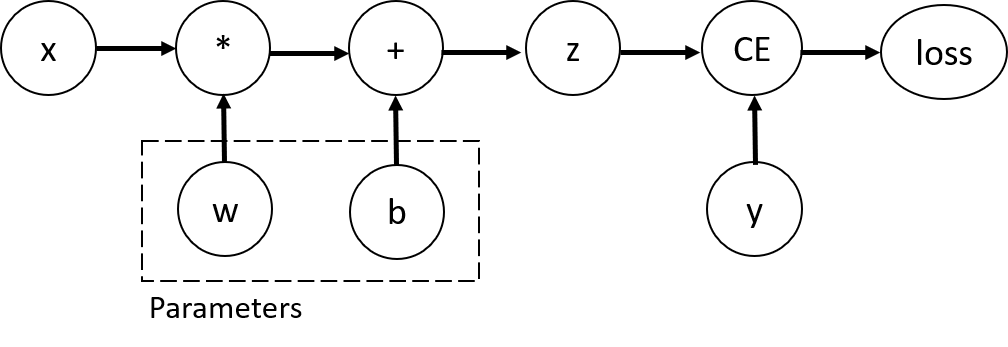

In [81]:
# read in packages
import torch

# create input, weights, bias, and compute output
x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

A function that we apply to tensors to construct computational graph is in fact an object of class Function. This object knows how to compute the function in the forward direction, and also how to compute its derivative during the backward propagation step. A reference to the backward propagation function is stored in grad_fn property of a tensor. 

In [82]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x3634809a0>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x363480e50>


### Computing Gradients

To optimize weights of parameters in the neural network, we need to compute the derivatives of our loss function with respect to parameters, namely, we need ∂loss / ∂w and ∂loss / ∂b under some fixed values of x and y

In [83]:
# compute gradients
loss.backward()
# print gradients
print(w.grad)
print(b.grad)

tensor([[0.2878, 0.2616, 0.2265],
        [0.2878, 0.2616, 0.2265],
        [0.2878, 0.2616, 0.2265],
        [0.2878, 0.2616, 0.2265],
        [0.2878, 0.2616, 0.2265]])
tensor([0.2878, 0.2616, 0.2265])


In [85]:
# EXERCISE — Verify gradients with a tiny example
# TODO:
#   1) Create a tiny linear model: y = xW + b
#   2) Define a simple loss: mean of outputs (or MSE to a target)
#   3) Call backward and print gradients
#   4) Confirm grads are not None and have expected shapes

x = torch.randn(4, 5)  # batch=4, features=5
W = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)



In [87]:
# EXERCISE 13 — Freeze parameters
# TODO:
#   1) Set requires_grad=False for W
#   2) Recompute forward + loss + backward
#   3) Confirm W.grad stays None (or zero) while b.grad updates

W2 = torch.randn(5, 3, requires_grad=True)
b2 = torch.randn(3, requires_grad=True)
x = torch.randn(4, 5)



### Disabling Gradient Tracking

TEST: Why would we want to disable gradient tracking?

## Optimizing Model Parameters

Training a model is an iterative process; in each iteration the model makes a guess about the output, calculates the error in its guess (loss), collects the derivatives of the error with respect to its parameters, and optimizes these parameters using gradient descent.

In [104]:
# all code so far
# read in packages
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

# read in data
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

# create data loaders
train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

# define the model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# create an instance of the model
model = NeuralNetwork()

### Hyperparameters

Hyperparameters are adjustable parameters that let you control the model optimization process. Different hyperparameter values can impact model training and convergence rates

In [105]:
# what do these do?
learning_rate = 1e-3
batch_size = 64
epochs = 5

Each epoch consists of two main parts:

The Train Loop - iterate over the training dataset and try to converge to optimal parameters.

The Validation/Test Loop - iterate over the test dataset to check if model performance is improving.

### Loss Function

Loss function measures the degree of dissimilarity of obtained result to the target value, and it is the loss function that we want to minimize during training. To calculate the loss we make a prediction using the inputs of our given data sample and compare it against the true data label value.

In [106]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

### Optimizer

Optimization is the process of adjusting model parameters to reduce model error in each training step. Optimization algorithms define how this process is performed (in this example we use Stochastic Gradient Descent). All optimization logic is encapsulated in the optimizer object.

In [91]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Inside the training loop, optimization happens in three steps:

Call optimizer.zero_grad() to reset the gradients of model parameters. Gradients by default add up; to prevent double-counting, we explicitly zero them at each iteration.

Backpropagate the prediction loss with a call to loss.backward(). PyTorch deposits the gradients of the loss w.r.t. each parameter.

Once we have our gradients, we call optimizer.step() to adjust the parameters by the gradients collected in the backward pass.

### Create Testing and Training Loops

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

In [ ]:
# EXERCISE — Add accuracy tracking to train_loop
# TODO:
#   1) Compute batch accuracy inside train_loop
#   2) Print both loss and accuracy every 100 batches




In [ ]:
# EXERCISE — Experiment with hyperparameters
# TODO:
#   1) Try learning_rate in {1e-2, 1e-3, 1e-4}
#   2) For each, train for 1-10 epoch and record test accuracy
#   3) Share which worked best!



In [ ]:
# EXERCISE — Test your own model you made above!
# Share the best accuracy you got



## Saving and Loading Models

PyTorch models store the learned parameters in an internal state dictionary, called state_dict. These can be persisted via the torch.save method:



In [97]:
# read in packages
import torch
import torchvision.models as models

# To load model weights, you need to create an instance of the same model first, and then load the parameters using load_state_dict() method.
model = models.vgg16(weights='IMAGENET1K_V1')
torch.save(model.state_dict(), 'model_weights.pth')

In [ ]:
# now we read in the weights
model = models.vgg16() # we do not specify ``weights``, i.e. create untrained model
model.load_state_dict(torch.load('model_weights.pth', weights_only=True))
model.eval()

<All keys matched successfully>

In [ ]:
# EXERCISE — Save & load your trained FashionMNIST model
# TODO:
#   1) Save your model's state_dict to disk
#   2) Create a new instance, load state_dict
#   3) Confirm predictions match on a fixed batch (same weights = same logits)
